# Main

In [1]:
"""Scripts for analyzing of phantom outputs.

This script analyze the json files written from the main frame and produce a plot.

"""

'Scripts for analyzing of phantom outputs.\n\nThis script analyze the json files written from the main frame and produce a plot.\n\n'

## Imports & Settings

In [2]:
#%matplotlib inline
import math
import numpy as np
from numpy import pi
#import pandas
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
#from moviepy.editor import ImageSequenceClip

In [3]:
# import modules listed in ./lib/

from lib import clmuphantomlib as mupl
from lib.clmuphantomlib.readwrite import json_load
from lib.clmuphantomlib.units_util import set_as_quantity, get_units_field_name

/home/clmu/anaconda3/envs/clmu_1/lib/python3.10/site-packages/sarracen/kernels/cubic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1/lib/python3.10/site-packages/sarracen/kernels/quartic_spline.py:15: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(fastmath=True)
/home/clmu/anaconda3/envs/clmu_1

    ## import modules in arbitrary directory
    
    #import sys
    
    ## path to my python module lib directory
    ## *** CHECK THIS! *** #
    #SRC_LIB_PATH = sys.path[0] + '/lib'
    
    #if SRC_LIB_PATH not in sys.path:
    #    sys.path.append(SRC_LIB_PATH)
    ##print(*sys.path, sep='\n')    # debug
    #print(
    #    "\n*   Please Make sure my module files are located in this directory (or change the SRC_LIB_PATH variable):",
    #    f"\n{SRC_LIB_PATH = }\n"
    #)

    # parallels & optimizations
    
    
    #import os
    ## Fixing stupid numba killing kernel
    ## See here https://github.com/numba/numba/issues/3016
    #os.environ['NUMBA_DISABLE_INTEL_SVML']  = '1'
    #from numba import njit, prange
    
    
    from multiprocessing import cpu_count, Process, Queue
    
    NPROCESSES = cpu_count()
    if NPROCESSES is None:
        NPROCESSES = 1
    NPROCESSES = max(NPROCESSES, 1)


In [6]:
# settings
#
#   imported from script_input.py file


from script_PhLocAxes__input import iverbose, unitsIn, unitsOut, PHOTOSPHERE_TAU, JOB_PROFILES, JOB_PROFILES_GROUPS


debug_times_yr = (-1., 0.5, 12., 20., 40.)

unitsOutTxt = {  key  : unitsOut[key].to_string('latex') for key in ['dist'] }
tounitsOut  = { unitsType: (1*unitsIn[unitsType]).to_value(unitsOut[unitsType]) for unitsType in unitsOut.keys()}


plt.rcParams.update({'font.size': 20})


# print debug info
if iverbose >= 2:
    #print(f"   Note: Will use {NPROCESSES} processes for parallelization")
    pass
    

# Analysis

## Photosphere size vs time

Debug:  ../photosphere/luis_2md/light
times_yr_inds  : [ 0.          0.75752451  1.26254085  1.51504902  1.76755719  2.02006536
  2.27257353  2.5250817   2.77758987  3.03009804  3.28260621  3.53511438
  3.78762255  4.04013072  4.29263889  4.54514706  4.79765523  5.0501634
  5.30267157  5.55517974  5.80768791  6.06019608  6.31270425  6.56521241
  6.81772058  7.07022875  7.32273692  7.57524509  8.08026143  8.3327696
  8.58527777  8.83778594 20.        ]
orbseps_au_inds: [2.55867612 2.52983458 2.50335881 2.42630296 2.32112199 2.19230499
 2.0513716  1.92428489 1.82509168 1.72966339 1.60836411 1.41919068
 1.16432636 0.94791105 0.80993795 0.61982267 0.53260373 0.43290011
 0.32394156 0.2780844  0.2466206  0.23228086 0.22093317 0.21850803
 0.21001657 0.20400841 0.20153979 0.20144038 0.2013519  0.19878127
 0.19523764 0.19290429 0.19290236]
time=0.0, y=2.178815218896539, y_err=0.26025487780552736
    y_data_xypm=array([2.16056352, 2.19372695, 2.14032277, 2.16428033, 2.16583136,
       2.24655859

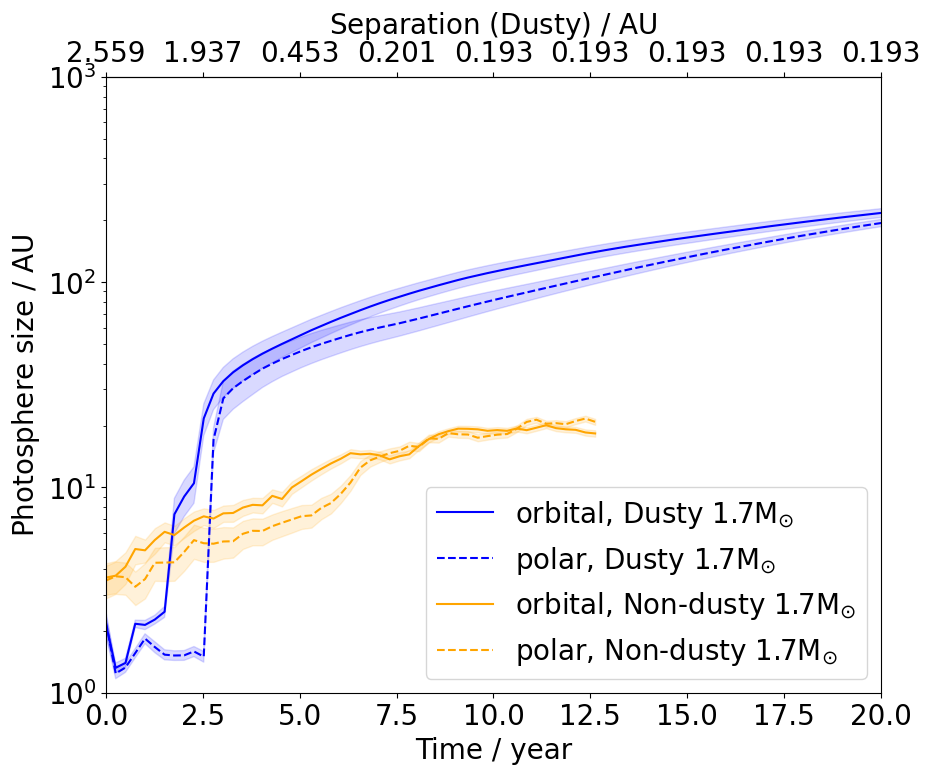

Debug:  ../photosphere/luis_4md/light
times_yr_inds  : [ 0.          0.25250817  0.50501634  1.01003268  1.26254085  1.51504902
  1.76755719  2.02006536  2.27257353  2.5250817   2.77758987  3.03009804
  3.28260621  3.53511438  3.78762255  4.04013072  4.29263889  4.54514706
  4.79765523  5.0501634   5.30267157  5.55517974  5.80768791  6.06019608
  6.31270425  6.56521241  6.81772058  7.07022875  7.32273692  7.57524509
  8.08026143  8.83778594  9.59531045 11.86788398 12.12039215 12.37290032
 13.63544117 14.89798202 20.        ]
orbseps_au_inds: [2.96341217 2.96286731 2.9579851  2.95153536 2.89376004 2.86035093
 2.82791578 2.78154471 2.71988305 2.64211765 2.55873554 2.47335158
 2.38042473 2.26283634 2.11166654 1.91524545 1.64491999 1.26009846
 0.8977833  0.44049424 0.26949729 0.15726407 0.1103882  0.08807392
 0.07649083 0.07300434 0.06868083 0.06280955 0.06264555 0.05837203
 0.05714545 0.05614853 0.05579529 0.05572647 0.05462643 0.05460694
 0.05447001 0.05442068 0.05442013]
time=0.0, y=2.1

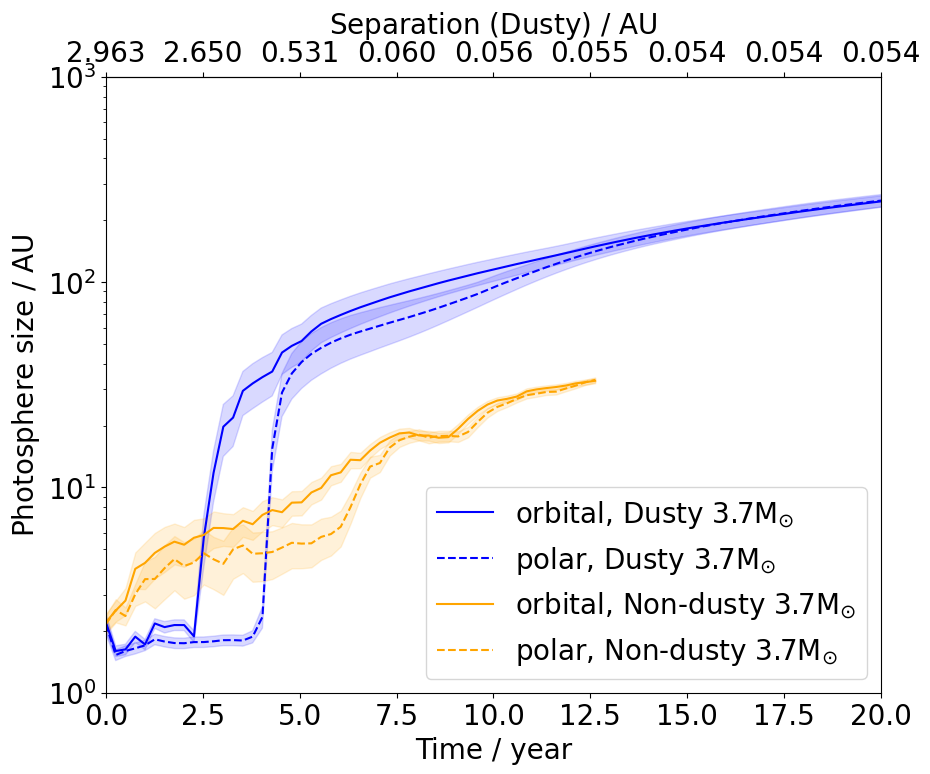

In [6]:
if __name__ == '__main__':

    # plotting

    #keys = rays_dir.keys()
    ylim = (1., 1000.)
    #x_use = 'time'
    
    xlims = {
        '2m': (0., 20.),
        '4m': (0., 20.),
    }
    
    for group_name in JOB_PROFILES_GROUPS.keys():
    
    
        fig, ax = plt.subplots(figsize=(10, 8))
        xlim = xlims[group_name]
        
        for i, job_profile in enumerate(JOB_PROFILES_GROUPS[group_name]):
            job_name = job_profile['job_name']
            with open(f"{job_name}__photospherePars__xyz.json", 'r') as f:
                photosphere_pars = json_load(f)
    
    
            times_yr = np.array(photosphere_pars['time_yr'])
            orbseps_au = np.array(photosphere_pars['orbsep_Rsun']) * tounitsOut['dist']
            x = times_yr
            
            if i == 0:
                # getting funcs for 2nd x axis transform, and
                # making sure orbseps_au is mono-decreasing, so np.interp doesn't freak out
                orbsep_tempmin = orbseps_au[0]
                x_inds = [0]
                for i in range(len(orbseps_au)):
                    if orbsep_tempmin > orbseps_au[i]:
                        orbsep_tempmin = orbseps_au[i]
                        x_inds.append(i)
                times_yr_inds   = times_yr[x_inds].copy()
                orbseps_au_inds = orbseps_au[x_inds].copy()
                if xlim[1] > times_yr_inds[-1]:
                    # add an end point so the secondary xaxis labels of orbsep does not freak out
                    times_yr_inds   = np.append(times_yr_inds, xlim[1])
                    orbseps_au_inds = np.append(orbseps_au_inds, orbseps_au_inds[-1]*(1.-1e-5))
                functions = (
                    lambda x: np.interp(x, times_yr_inds, orbseps_au_inds),
                    lambda x: np.interp(x, orbseps_au_inds[::-1], times_yr_inds[::-1]),
                )
                if iverbose >= 3:
                    print(f"Debug:  {job_name}\ntimes_yr_inds  : {times_yr_inds}\norbseps_au_inds: {orbseps_au_inds}")
                
                
            y_data_xypm     = np.array([photosphere_pars['data'][key]['size'] for key in ('+x', '-x', '+y', '-y',)])
            y_err_data_xypm = np.array([photosphere_pars['data'][key]['h'] for key in ('+x', '-x', '+y', '-y',)])
            y     = np.average(    y_data_xypm**2, axis=0)**0.5 * tounitsOut['dist']
            y_err = np.average(y_err_data_xypm**2, axis=0)**0.5 * tounitsOut['dist']
    
            ax.semilogy(x, y, '-', color=job_profile['color'], label=f"orbital, {job_profile['name']}")    
            ax.fill_between(x, y-y_err, y+y_err, color=job_profile['color'], alpha=0.15)
            if iverbose >= 4:
                print(f"Photosphere size(orbital):\n time(yr): size({unitsOutTxt['dist']})\n{ {x_i : y_i for x_i, y_i in zip(x, y)} }")
            
            
            y_data_zpm     = np.array([photosphere_pars['data'][key]['size'] for key in ('+z', '-z',)])
            y_err_data_zpm = np.array([photosphere_pars['data'][key]['h'] for key in ('+z', '-z',)])
            y     = np.average(    y_data_zpm**2, axis=0)**0.5 * tounitsOut['dist']
            y_err = np.average(y_err_data_zpm**2, axis=0)**0.5 * tounitsOut['dist']
    
            ax.semilogy(x, y, '--', color=job_profile['color'], label=f"polar, {job_profile['name']}")
            ax.fill_between(x, y-y_err, y+y_err, color=job_profile['color'], alpha=0.15)
            if iverbose >= 4:
                print(f"Photosphere size(polar):\n time(yr): size({unitsOutTxt['dist']})\n{ {x_i : y_i for x_i, y_i in zip(x, y)} }")

            if iverbose >= 3:
                for debug_time_yr in debug_times_yr:
                    debug_inds = np.where(np.array(photosphere_pars['time_yr']) > debug_time_yr)[0]
                    if len(debug_inds):
                        debug_ind = debug_inds[0]
                        all_axes_names = ('+x', '-x', '+y', '-y', '+z', '-z')
                        time = photosphere_pars['time_yr'][debug_ind]
                        y_data_xypm     = np.array([photosphere_pars['data'][key]['size'][debug_ind] for key in all_axes_names]
                                                  ) * tounitsOut['dist']
                        y_err_data_xypm = np.array([photosphere_pars['data'][key]['h'][debug_ind] for key in all_axes_names]
                                                  ) * tounitsOut['dist']
                        y     = np.average(    y_data_xypm**2, axis=0)**0.5
                        y_err = np.average(y_err_data_xypm**2, axis=0)**0.5
                        print(f"{time=}, {y=}, {y_err=}\n    {y_data_xypm=}\n    {y_err_data_xypm=}")
                    
            
    
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xlabel("Time / year")
        ax.set_ylabel(f"Photosphere size / {unitsOutTxt['dist']}")
        
        secax = ax.secondary_xaxis('top', functions=functions)
        secax.set_xlabel(f"Separation (Dusty) / {unitsOutTxt['dist']}")
        secax.set_ticks(functions[0](ax.get_xticks()))
        #secax.set_ticks(ax.get_xticks())
        
        #ax.text(
        #    0.98, 0.98,
        #    f"$\\mu = {mu} $",
        #    color = "black", ha = 'right', va = 'top',
        #    transform=ax.transAxes,
        #)
        ax.legend(loc="lower right")
        #ax.set_title("Photosphere size\n" + f"resolution = {mpdf.params['nparttot']:.2e}",)
    
    
        outfilename_x = 't+sep'
        outfilename_noext = f"fig__{group_name}__photosphereSize-{outfilename_x}__xyz"
        fig.savefig(f"{outfilename_noext}.pdf")
        fig.savefig(f"{outfilename_noext}.png")
        plt.show()
        plt.close(fig)

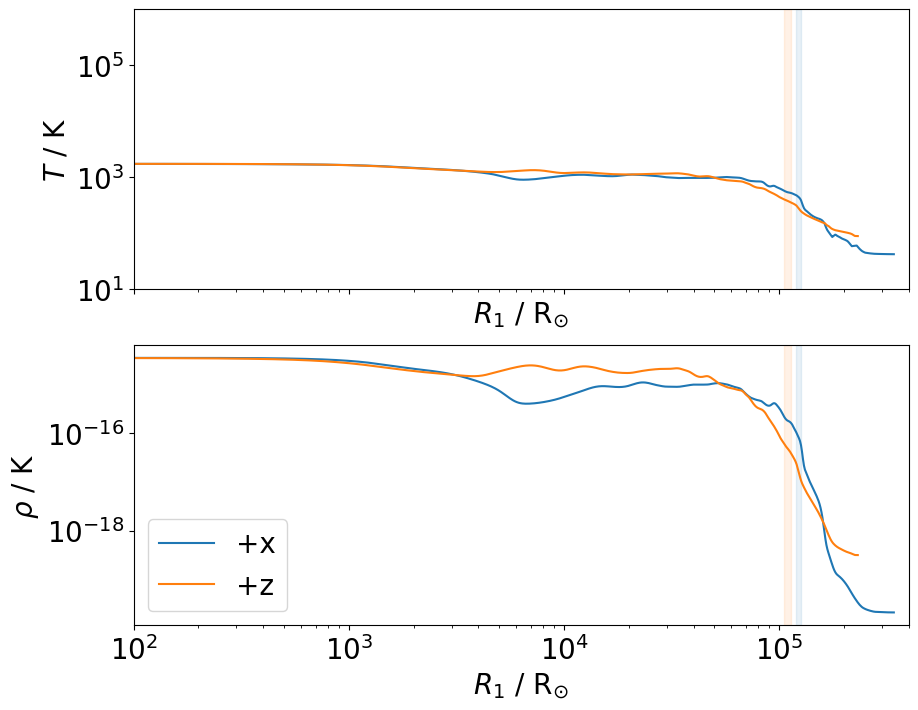

In [73]:
# Temp vs Rad plots

if __name__ == '__main__':

    # settings
    xlim = (1e2, 4e5)
    labels = ['+x', '+z']    # name of the ray to be plotted
    quans  = ['rho', 'T']    # quantities to be plotted
    ylims  = {
        'T'  : (1e1, 1e6),
        'rho': None,
    }
    ylabels = {
        'T'  : "$T$",
        'rho': "$ \\rho $",
    }
    

    # plotting
    job_profile = JOB_PROFILES[1]
    job_name    = job_profile['job_name']
    file_index = job_profile['file_indexes'][-1]

    with open(f"{mupl.get_filename_phantom_dumps(job_name, file_index)}__photospherePars__xyz.json", 'r') as f:
        photosphere_pars = json_load(f)

    time_yr = photosphere_pars['time_yr']
    orbsep_Rsun = np.array(photosphere_pars['orbsep_Rsun'])


    fig, axes = plt.subplots(len(quans), figsize=(10, 8), squeeze=False, sharex=True)

    for i, label in enumerate(labels):
        photosphere = photosphere_pars['data'][label]
        for ax, quan in zip(axes, quans):
            ax = ax[0]
            ylim = ylims[quan] if quan in ylims.keys() else None
            ylabel = ylabels[quan] if quan in ylabels.keys() else None
            unit_name = get_units_field_name(quan)
            ax.loglog(
                photosphere['R1_on_ray'],
                set_as_quantity(photosphere[f'{quan}_on_ray'], unit=unitsIn[unit_name]).to_value(unitsOut[unit_name]),
                color=f'C{i}', label=label)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.fill_betweenx(
                ax.get_ylim(),
                photosphere['R1']-photosphere['h'], photosphere['R1']+photosphere['h'],
                color=f'C{i}', alpha=0.1)
            ax.set_xlabel(f"$R_1$ / {units.Rsun.to_string('latex_inline')}")
            ax.set_ylabel(f"{ylabel} / {units.K.to_string('latex_inline')}")
    ax.legend(loc='lower left')

In [14]:
get_units_field_name('T')

'temp'

In [25]:
photosphere

{'is_found': True,
 'loc': array([ 8.85291853e+02, -4.64853557e+01,  9.52148484e-02]),
 'R1': 810.2669786181984,
 'rho': array(1.52835255e-13),
 'u': array(0.00309423),
 'h': 291.726138832665,
 'T': 4661.519468891436,
 'size': 810.2669786181984,
 'R1_on_ray': array([1796.30632321, 1786.99674577, 1777.73541636, 1768.52208492,
        1759.35650269, 1750.23842222, 1741.16759732, 1732.14378307,
        1723.16673585, 1714.23621328, 1705.35197423, 1696.51377884,
        1687.72138848, 1678.97456576, 1670.27307452, 1661.61667982,
        1653.00514795, 1644.43824639, 1635.91574385, 1627.43741023,
        1619.0030166 , 1610.61233526, 1602.26513964, 1593.96120439,
        1585.7003053 , 1577.48221934, 1569.3067246 , 1561.17360038,
        1553.08262706, 1545.0335862 , 1537.02626048, 1529.06043371,
        1521.13589081, 1513.25241783, 1505.40980191, 1497.6078313 ,
        1489.84629537, 1482.12498454, 1474.44369035, 1466.80220541,
        1459.2003234 , 1451.63783908, 1444.11454826, 1436.630

In [25]:
(1.3740183545076838*units.au).to(units.Rsun)

<Quantity 295.4581287 solRad>

In [19]:
y

31.838427465230787